In [1]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [2]:
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [3]:
#use this cell when working online
path = '/floyd/home/ed-triage'
data_path = '/floyd/home/data/bch'
model_path = 'floyd/home/models'

In [4]:
data = pd.read_csv(data_path + '/100kcompleterecords.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data = data[['CleanSubjectiveNotes','pmhx', 'outcome', 'target', 'service', 'target2',
       'discharge', 'target3', 'dispo', 'target4', 'ICUvsother', 'target5']]

In [6]:
data.columns

Index(['CleanSubjectiveNotes', 'pmhx', 'outcome', 'target', 'service',
       'target2', 'discharge', 'target3', 'dispo', 'target4', 'ICUvsother',
       'target5'],
      dtype='object')

In [7]:
data.head()

,CleanSubjectiveNotes,pmhx,outcome,target,service,target2,discharge,target3,dispo,target4,ICUvsother,target5
0,patient states that she feels shaky. patient d...,no significant medical history,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0
1,NaN,substance misuse,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0
2,patient states no pain.,no significant medical history,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0
3,denied chest pain,no significant medical history,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0
4,denies pain. eating emergency department lunch...,"dialysis haemo/pd,iddm,crf,heart problem,high ...",discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0


In [8]:
data.shape

(102492, 12)

In [9]:
data.dropna(subset = ['CleanSubjectiveNotes','pmhx'], inplace = True)
data.shape

(101941, 12)

In [10]:
#language model databunch based on full dataset
data_lm = (TextList.from_df(data, cols=['CleanSubjectiveNotes','pmhx'])
                   .split_by_rand_pct(0.2)
                   .label_for_lm()
                   .databunch())

In [11]:
#classification databunch for small dataset and languange model
data_clas = (TextList.from_df(data, cols=['CleanSubjectiveNotes','pmhx'],vocab=data_lm.vocab)
                   .split_by_rand_pct(0.2)
                   .label_from_df(cols = 'discharge')
                   .databunch())

In [12]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.390321,3.240347,0.364240,01:29
1,3.191934,3.089038,0.379347,01:28
2,3.097337,3.049780,0.383722,01:28


epoch,train_loss,valid_loss,accuracy,time
0,2.940806,2.895258,0.404277,01:44
1,2.836895,2.794933,0.418350,01:44
2,2.677906,2.690735,0.432207,01:44
3,2.477823,2.613747,0.444408,01:44
4,2.295654,2.617158,0.445427,01:44


In [16]:
#the above training scheme is good so I'm going to save this as my language model
#which is basically saving the embedding matrix from the language modelling nerual network
lmlearn.save_encoder(path + '/edsent_v3_enc')

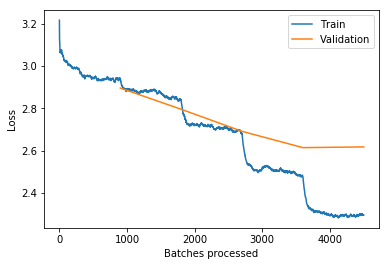

In [14]:
lmlearn.recorder.plot_losses()

All that work was done to get the best language model I could get which seems to have
accuracy of about 48%

Now on to training the classifier

In [19]:
f1 = FBeta(beta=1, average = 'weighted')
def train_triage_classifier(encoder_name, datac = data_clas, datal = data_lm, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model.load_encoder(path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.259834,0.260721,0.904650,0.863896,00:55


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.279554,0.257134,0.905287,0.866436,01:03


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.274665,0.255170,0.905729,0.868699,01:33


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.262399,0.254705,0.905533,0.869511,02:05
1,0.246354,0.254587,0.905925,0.870583,02:09
2,0.250822,0.254637,0.905631,0.870703,02:07
3,0.244617,0.254453,0.905925,0.870733,02:04
4,0.247945,0.254364,0.905974,0.871210,02:10


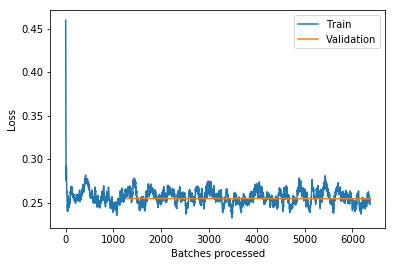

In [20]:
sent_learn = train_triage_classifier('edsent_v3_enc', datac = data_clas, num_cycles = 1, lr = 1e-3)

In [21]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

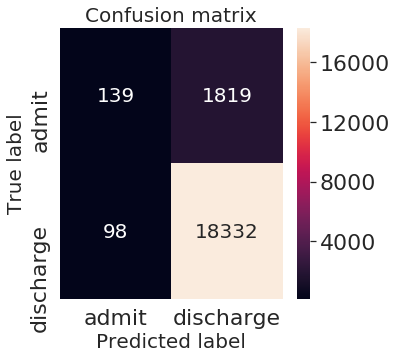

In [22]:
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [25]:
f1_w = sklearn.metrics.f1_score(targets, predictions, average='weighted')
f1 = sklearn.metrics.f1_score(targets, predictions, average=None)
acc = sklearn.metrics.accuracy_score(targets, predictions)
prec = sklearn.metrics.precision_score(targets,predictions, average = None)
rec = sklearn.metrics.recall_score(targets,predictions, average = None)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)

weighted f1:  0.8712105081031505
f1:           [0.126651 0.950312]
accuracy:     0.9059741024131842
precision:    [0.586498 0.909732]
recall:       [0.070991 0.994683]


In [27]:
sent_learn.save(path + '/models/edsentv3')